# Implemneting Portfolio Insurance (CPPI) and Drawdown Constraint

In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import edhec_risk_kit as erk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Applications/SelfStudy/PythonForPortfolio/Module 3/edhec_risk_kit.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data/ind30_m_vw_rets.csv", header = 0, index_col = 0, parse_dates= True) /100
/Applications/SelfStudy/PythonForPortfolio/Module 3/edhec_risk_kit.py:65: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("../data/ind30_m_vw_rets.csv", header = 0, index_col = 0, parse_dates= True) /100
/Applications/SelfStudy/PythonForPortfolio/Module 3/edhec_risk_kit.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv(".

In [66]:
risky_r = ind_return["2000":][["Steel","Fin","Beer"]]

In [67]:
risky_r.shape

(228, 3)

In [68]:
safe_r = pd.DataFrame().reindex_like(risky_r)

In [69]:
safe_r.shape

(228, 3)

In [70]:
safe_r[:]= 0.03/12
start = 1000
floor = 0.8

1. Cushion
Asset Value - Floor Value
2. Compute an allocation to Safe and Risky Asset
m * risk budget
3. Recompute the Asset Valyue Based on the returns


In [ ]:
def compound1(r):
    return (1+r).prod()-1
def compound2(r):
    # return np.expm1(np.log1p(r).sum()) is okay too
    return np.exp(np.log(1+r).sum())-1

In [72]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [ ]:
# %timeit compund1(risky_r)

81 μs ± 1.16 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# %timeit coumpound2(risky_r)

128 μs ± 13.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Let's back to CPPI

In [75]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value-floor_value)/account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w,1)
    risky_w = np.maximum(risky_w,0)
    safe_w = 1 - risky_w

    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    ## update the account value for this time step
    account_value = (risky_alloc * (1 + risky_r.iloc[step])) + (safe_alloc * (1 + safe_r.iloc[step]))
    # safe the values so that I can look at the history and plot it etc
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value


In [76]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


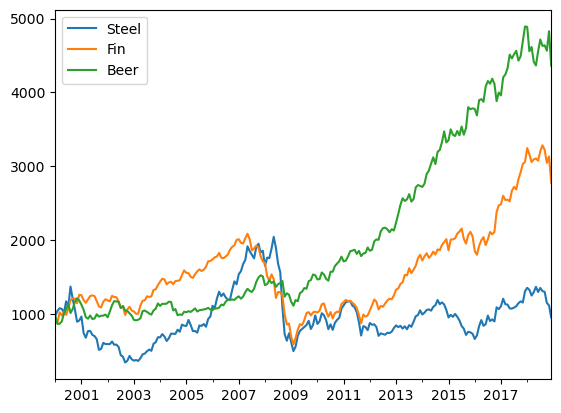

In [77]:
risky_wealth = start * (1+risky_r).cumprod()
risky_wealth.plot()
plt.show()

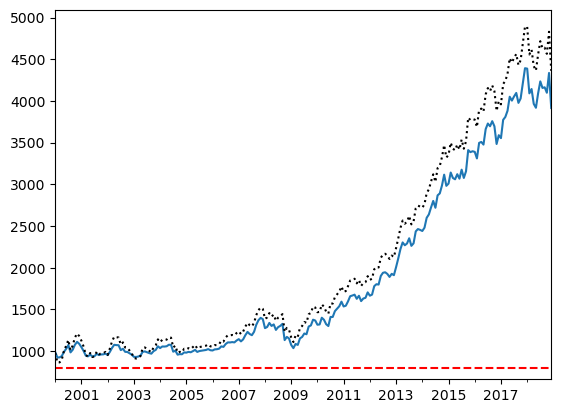

In [78]:
ax = account_history["Beer"].plot()
risky_wealth["Beer"].plot(ax = ax, style="k:")
ax.axhline(y=floor_value, color='r',linestyle = "--")
plt.show()

In [79]:
risky_w_history.plot()

<Axes: >

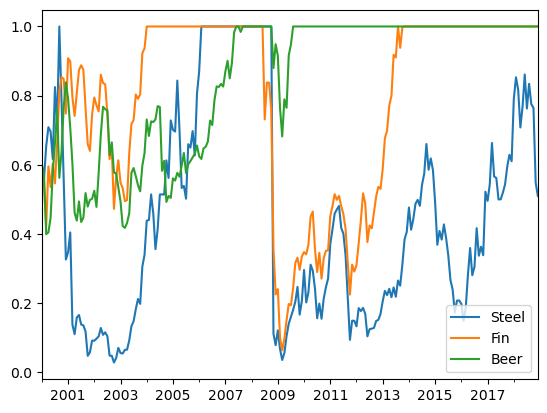

In [80]:
plt.show()

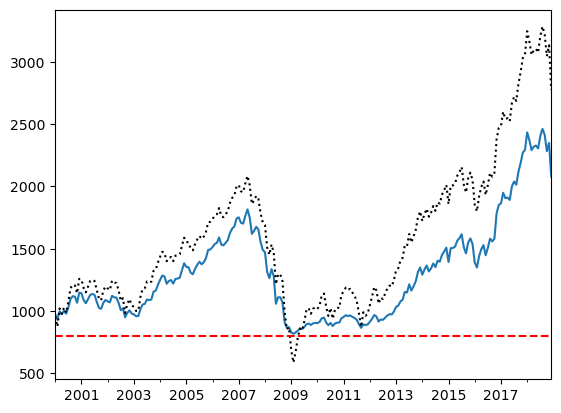

In [81]:
ind="Fin"
ax = account_history["Fin"].plot()
risky_wealth["Fin"].plot(ax = ax, style="k:")
ax.axhline(y = floor_value, color= 'r', linestyle="--")
plt.show()

In [82]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [83]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


## Drawdown Constraint

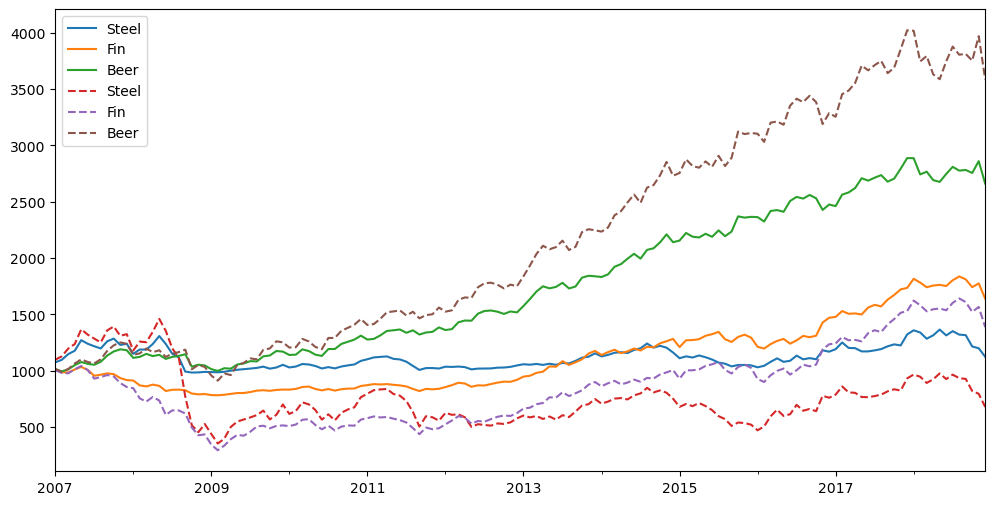

In [85]:
btr = erk.run_cppi(ind_return["2007":][["Steel","Fin","Beer"]], drawdown = 0.25)
ax = btr["Wealth"].plot(figsize = (12,6))
btr["Risky Wealth"].plot(ax = ax, style = "--")
plt.show()

In [ ]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [87]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
